# Analyzing Storm Data

## Import the required packages.

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from amazon_cred import ENDPOINT, PORT, USER, PASSWORD, DATABASE
from data_constants import BLS_CPI_CSV

# Regression Analysis

Steps
1. Get data from the database
2. Consider only rows that belong to the 3 storm categories
3. Adjust the total damage using to 2020 dollars consumer price index
4. Split data into major storm categories: Tropical Cyclones/Floods, Tornadoes, Wildfires
5. Split each category data into train, test
6. String variables should be one hot encoded
7. Apply scaling

In [2]:
conn = psycopg2.connect(
    host=ENDPOINT,
    port=PORT,
    user=USER,
    password=PASSWORD,
    database = DATABASE
)
with conn:
    select = """SELECT * from counties"""
    df_counties = pd.read_sql(select, con=conn)
conn.close()

In [3]:
analysis_df = df_counties[['TOTAL_DAMAGE', 'EVENT_DATE', 'EVENT_TYPE', 
                           'DURATION', 'DATA_COL', 'TORNADO_STRENGTH',
                           'Tropical Cyclones/Floods', 'Severe Local Storms', 'Wildfires/Droughts']]
analysis_df = analysis_df[(analysis_df['Tropical Cyclones/Floods'] == True) |
                          (analysis_df['Severe Local Storms'] == True) |
                          (analysis_df['Wildfires/Droughts'] == True)]
# Split the DATA_COL into individual columns
data_cols = [
    'population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
    'rank_1_ind', 'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp', 
    'rank_2_ind', 'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp', 
    'rank_3_ind', 'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp'
]

analysis_df.reset_index(inplace=True, drop=True)
analysis_df['DATA_COL'] = analysis_df['DATA_COL'].apply(lambda data: [i for i in data.split('|') if i != ' '])

data_df = pd.DataFrame(analysis_df['DATA_COL'].to_list(), columns=data_cols)
analysis_df = pd.concat([analysis_df, data_df], axis=1)

# Convert columns to numeric data
num_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp']
for c in num_cols:
    analysis_df[c] = analysis_df[c].apply(pd.to_numeric, errors='coerce')
    analysis_df[c] = analysis_df[c].fillna(analysis_df[c].median())

In [4]:
categorical_attributes = ['EVENT_TYPE', 'EVENT_DATE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind', 
                          'TORNADO_STRENGTH', 'Tropical Cyclones/Floods', 'Severe Local Storms', 
                          'Wildfires/Droughts']
# Remove records which have very few industries
analysis_df.rank_1_ind.value_counts()

Retail                                                                      4561
Manufacturing                                                               3969
Wholesale                                                                   2280
Health Care and Social Assistance                                            496
Professional, Scientific, and Technical Services                             106
Accommodation and Food Services                                               55
Transportation and Warehousing                                                50
NaN                                                                           38
Administrative and Support and Waste Management and Remediation Services       2
Real Estate Rental and Leasing                                                 2
Arts, Entertainment, and Recreation                                            1
Other Services (except Public Administration)                                  1
Name: rank_1_ind, dtype: int

In [5]:
rank_1_ind_to_rem = ['NaN', 'Administrative and Support and Waste Management and Remediation Services',
                     'Real Estate Rental and Leasing', 'Arts, Entertainment, and Recreation',
                     'Other Services (except Public Administration)']
analysis_df = analysis_df.drop(analysis_df[analysis_df.rank_1_ind.isin(rank_1_ind_to_rem)].index, axis=0)
analysis_df.rank_1_ind.value_counts()

Retail                                              4561
Manufacturing                                       3969
Wholesale                                           2280
Health Care and Social Assistance                    496
Professional, Scientific, and Technical Services     106
Accommodation and Food Services                       55
Transportation and Warehousing                        50
Name: rank_1_ind, dtype: int64

In [6]:
rank_2_ind_to_rem = ['Information', 'Finance and Insurance']
analysis_df = analysis_df.drop(analysis_df[analysis_df.rank_2_ind.isin(rank_2_ind_to_rem)].index, axis=0)
analysis_df.rank_2_ind.value_counts()

Retail                                                                      4822
Health Care and Social Assistance                                           2493
Wholesale                                                                   1667
Manufacturing                                                               1531
Accommodation and Food Services                                              341
Professional, Scientific, and Technical Services                             246
Transportation and Warehousing                                               160
Other Services (except Public Administration)                                111
Administrative and Support and Waste Management and Remediation Services      70
Real Estate Rental and Leasing                                                27
Utilities                                                                     25
Arts, Entertainment, and Recreation                                           22
Name: rank_2_ind, dtype: int

In [7]:
rank_3_ind_to_rem = ['Finance and Insurance', 'Educational Services', 'NaN']
analysis_df = analysis_df.drop(analysis_df[analysis_df.rank_3_ind.isin(rank_3_ind_to_rem)].index, axis=0)
analysis_df.rank_3_ind.value_counts()

Health Care and Social Assistance                                           4343
Retail                                                                      1707
Wholesale                                                                   1571
Manufacturing                                                               1173
Accommodation and Food Services                                              856
Professional, Scientific, and Technical Services                             816
Other Services (except Public Administration)                                447
Transportation and Warehousing                                               282
Administrative and Support and Waste Management and Remediation Services     133
Real Estate Rental and Leasing                                                89
Arts, Entertainment, and Recreation                                           46
Utilities                                                                     24
Information                 

## Apply the inflation adjustment to dollar figures for each event

In [8]:
df_bls_cpi = pd.read_csv(BLS_CPI_CSV)
df_cpi_2020 = df_bls_cpi[df_bls_cpi['year']==2020] # adjust damage to 2020 dollars
df_cpi_2020.reset_index(drop=True, inplace=True) # inflation for month 12 is at iloc 0;

def apply_inflation(row):
    event_year = row['EVENT_DATE'].year
    event_mth = row['EVENT_DATE'].month
    
    df_cpi_year = df_bls_cpi[df_bls_cpi['year']==event_year]
    df_cpi_year.reset_index(drop=True, inplace=True)

    frac = (df_cpi_2020.iloc[12 - event_mth]['value']/df_cpi_year[df_cpi_year['period']==event_mth].iloc[0]['value'])
    
    row['TOTAL_DAMAGE'] = row['TOTAL_DAMAGE'] * frac
    row['annual_payroll'] = row['annual_payroll'] * frac
    row['non_emp_revenue'] = row['non_emp_revenue'] * frac
    row['rank_1_biz_val'] = row['rank_1_biz_val'] * frac
    row['rank_2_biz_val'] = row['rank_2_biz_val'] * frac
    row['rank_3_biz_val'] = row['rank_3_biz_val'] * frac
    return row

analysis_df = analysis_df.apply(apply_inflation, axis=1)
analysis_df.drop(columns=['DATA_COL', 'EVENT_DATE'], inplace = True)
analysis_df['DURATION'] = analysis_df['DURATION']/(60*1e9) # convert the duration in minutes (from nanosec)

In [9]:
# Some attributes skewed to the right (mean > median), some skewed to the left (mean < median)
analysis_df.describe()

,TOTAL_DAMAGE,DURATION,population,num_estab,annual_payroll,num_emp,num_non_emp_estb,non_emp_revenue,rank_1_biz_val,rank_1_estab,rank_1_emp,rank_2_biz_val,rank_2_estab,rank_2_emp,rank_3_biz_val,rank_3_estab,rank_3_emp
count,1.150300e+04,11503.000000,1.150300e+04,11503.000000,1.150300e+04,1.150300e+04,11503.000000,1.150300e+04,1.150300e+04,11503.000000,11503.000000,1.150300e+04,11503.000000,11503.000000,1.150300e+04,11503.000000,11503.000000
mean,4.368691e+07,8266.398592,2.335064e+05,5683.637051,4.976707e+06,9.376139e+04,17320.190907,9.596010e+05,7.421023e+06,660.270712,12576.515778,4.005890e+06,699.331566,13952.214466,2.882421e+06,779.140920,14261.320960
std,4.015831e+08,26570.876606,5.978894e+05,14735.532710,1.551306e+07,2.558853e+05,48197.608017,2.828899e+06,2.535296e+07,2019.449605,30912.268167,1.240188e+07,1736.291584,37405.896149,8.534743e+06,2496.760068,47462.436657
min,9.524471e+05,0.000000,4.180000e+02,10.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,1.667017e+06,15.000000,1.768900e+04,372.000000,1.398201e+05,4.084000e+03,1100.000000,4.877652e+04,2.762492e+05,36.000000,707.000000,1.270379e+05,43.000000,544.000000,5.825868e+04,40.000000,415.000000
50%,3.782668e+06,360.000000,4.876700e+04,1050.000000,5.084059e+05,1.345700e+04,3054.000000,1.413366e+05,1.020298e+06,103.000000,2745.000000,5.120381e+05,144.000000,2059.000000,2.702487e+05,120.000000,1753.000000
75%,1.196269e+07,3360.000000,1.713240e+05,4173.000000,2.573015e+06,6.084900e+04,11027.000000,5.910100e+05,4.219424e+06,449.500000,10055.000000,2.431630e+06,507.000000,9102.500000,1.606388e+06,446.500000,7863.500000
max,2.368906e+10,505439.000000,9.758746e+06,253004.000000,2.755856e+08,3.910429e+06,875747.000000,5.886965e+07,5.532389e+08,44143.000000,578206.000000,2.262263e+08,17368.000000,545411.000000,1.518032e+08,54456.000000,945410.000000


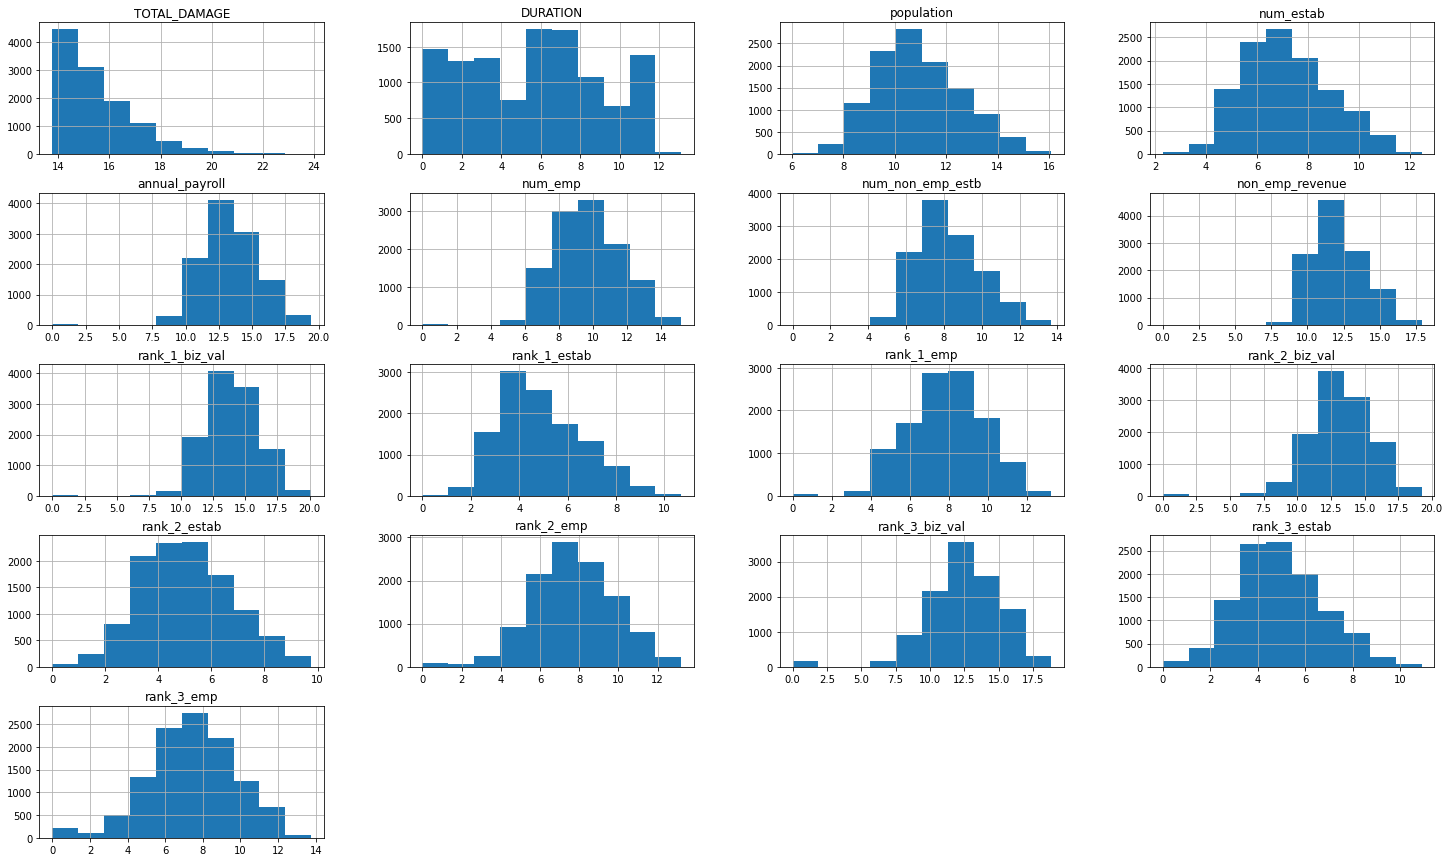

In [10]:
lst_num_cols = []
categorical_attributes = ['EVENT_TYPE', 'EVENT_DATE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind', 
                          'TORNADO_STRENGTH', 'Tropical Cyclones/Floods', 'Severe Local Storms', 
                          'Wildfires/Droughts']

# log-log model
def apply_log(df):
    for c in df.columns:
        if c not in categorical_attributes:
            lst_num_cols.append(c)
            df[c] = np.log(df[c].mask(df[c] <= 0)).fillna(0)
    return df
analysis_df = apply_log(analysis_df)

# visualize distributions
analysis_df[lst_num_cols].hist(figsize=(25,15))
plt.show() # Target variable TOTAL_DAMAGE has a long tail 

## Split data into major storm categories: Tropical Cyclones/Floods, Tornadoes, Wildfires

In [11]:
cat1_df = analysis_df[analysis_df['Tropical Cyclones/Floods'] == True]
cat2_df = analysis_df[analysis_df['EVENT_TYPE'] == 'Tornado']
cat3_df = analysis_df[analysis_df['Wildfires/Droughts'] == True]

cat1_df = cat1_df.drop(columns = ['TORNADO_STRENGTH', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])
cat2_df = cat2_df.drop(columns = ['EVENT_TYPE', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])
cat3_df = cat3_df.drop(columns = ['TORNADO_STRENGTH', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])

def split_tornado_strength(row):
    cols = row['TORNADO_STRENGTH'].split(',')
    row['Tornado_f_scale'] = int(cols[0][-1])
    row['Tornado_len'] = float(cols[1])
    row['Tornado_width'] = float(cols[2])
    return row
cat2_df = cat2_df.apply(split_tornado_strength, axis=1)
cat2_df.drop(columns = ['TORNADO_STRENGTH'], inplace=True)

In [12]:
cat1_df.columns

Index(['TOTAL_DAMAGE', 'EVENT_TYPE', 'DURATION', 'population', 'num_estab',
       'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
       'rank_1_ind', 'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
       'rank_2_ind', 'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
       'rank_3_ind', 'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp'],
      dtype='object')

### Correlation matrix after applying scaling

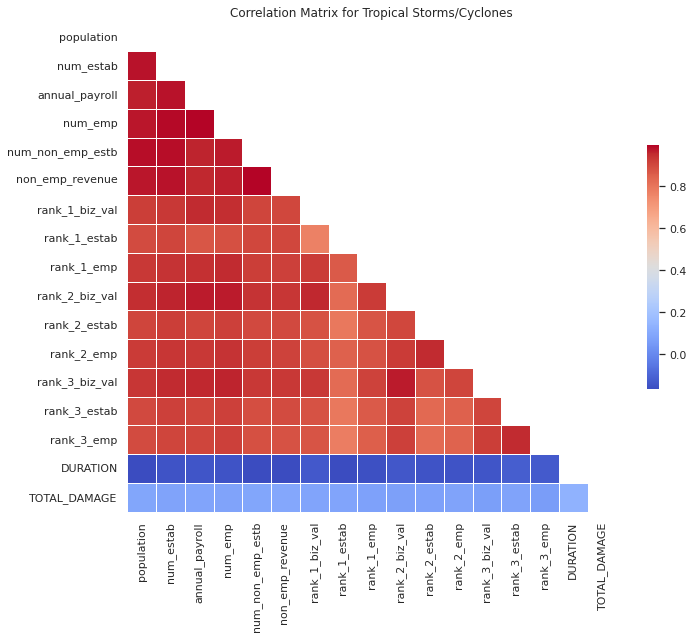

In [13]:
def apply_scaling(df):
    for col in df:
        if col not in ['EVENT_TYPE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind']:
            scaler = StandardScaler()
            df[col] = scaler.fit_transform(df[col].values.reshape([-1,1]))
        else:
            continue
    return df

sns.set_theme(style="white")

lst_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp', 'DURATION', 'TOTAL_DAMAGE',
            'EVENT_TYPE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind'
           ]

cat1_df = cat1_df[lst_cols]
cat1_df = apply_scaling(cat1_df)

# Compute the correlation matrix
corr_cat1 = cat1_df.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_cat1, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Correlation Matrix for Tropical Storms/Cyclones')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_cat1, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});


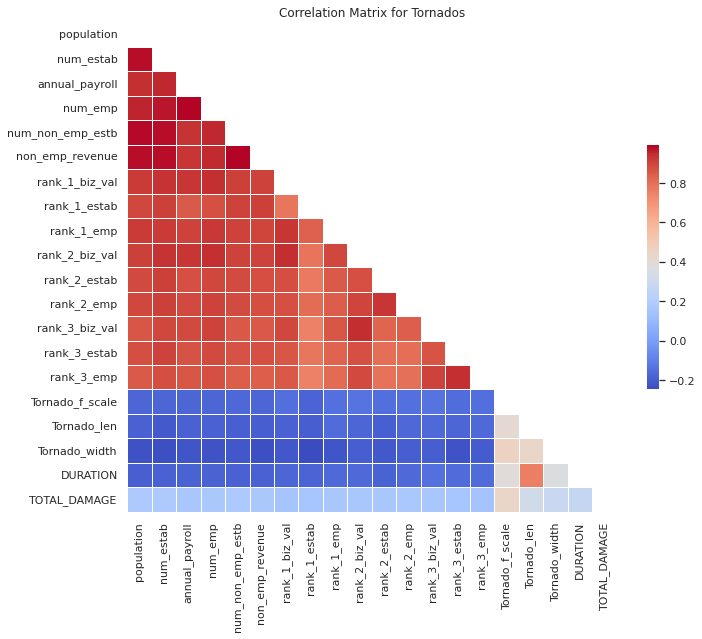

In [14]:
lst_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp', 
            'Tornado_f_scale', 'Tornado_len', 'Tornado_width', 'DURATION', 'TOTAL_DAMAGE',
            'rank_1_ind', 'rank_2_ind', 'rank_3_ind'
           ]

cat2_df = cat2_df[lst_cols]
cat2_df = apply_scaling(cat2_df)

# Compute the correlation matrix
corr_cat2 = cat2_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_cat2, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Correlation Matrix for Tornados')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_cat2, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

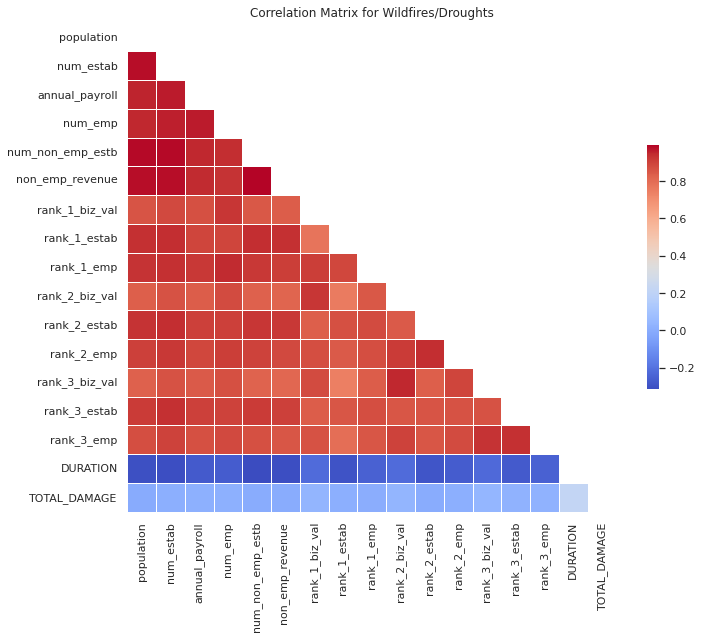

In [15]:
lst_cols = ['population', 'num_estab', 'annual_payroll', 'num_emp', 'num_non_emp_estb', 'non_emp_revenue',
            'rank_1_biz_val', 'rank_1_estab', 'rank_1_emp',
            'rank_2_biz_val', 'rank_2_estab', 'rank_2_emp',
            'rank_3_biz_val', 'rank_3_estab', 'rank_3_emp', 'DURATION', 'TOTAL_DAMAGE',
            'EVENT_TYPE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind'            
           ]

cat3_df = cat3_df[lst_cols]
cat3_df = apply_scaling(cat3_df)

# Compute the correlation matrix
corr_cat3 = cat3_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_cat3, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_title('Correlation Matrix for Wildfires/Droughts')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_cat3, mask=mask, cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [16]:
# correlation with TOTAL_DAMAGE
corr_cat3.TOTAL_DAMAGE.sort_values(ascending=False)

TOTAL_DAMAGE        1.000000
DURATION            0.219177
rank_3_biz_val      0.039571
rank_1_biz_val      0.036557
rank_2_biz_val      0.036329
rank_3_estab        0.023702
rank_3_emp          0.022087
num_emp             0.014519
annual_payroll      0.011662
rank_1_estab        0.009689
num_estab           0.008353
rank_2_emp          0.008116
rank_1_emp          0.004243
rank_2_estab        0.000452
non_emp_revenue    -0.000808
num_non_emp_estb   -0.003855
population         -0.005555
Name: TOTAL_DAMAGE, dtype: float64

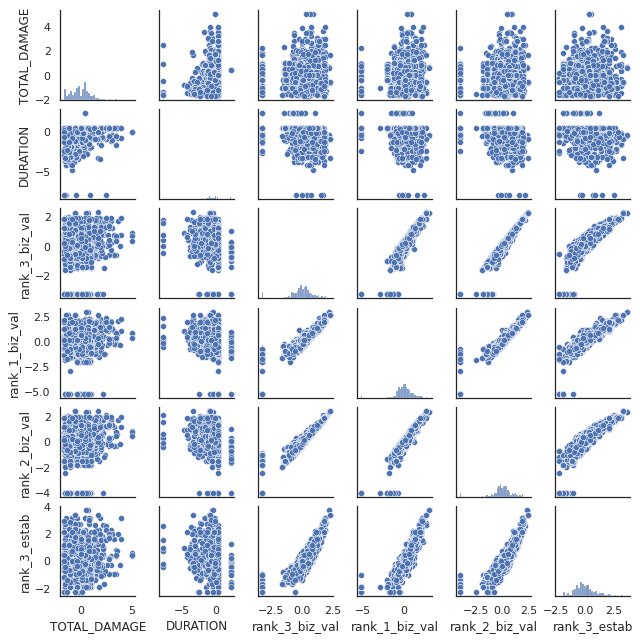

In [17]:
# visualizing relations of most related attributes
attributes = ['TOTAL_DAMAGE', 'DURATION', 'rank_3_biz_val', 'rank_1_biz_val', 'rank_2_biz_val', 'rank_3_estab']
sns.pairplot(cat3_df[attributes], height=1.5)
plt.show()
# Note: not enough opportunity for feature engineering

### Regression Analysis using Ordinary Least Squares (Tropical Storms/Cyclones)

In [18]:
import statsmodels.formula.api as smf

formula = 'TOTAL_DAMAGE ~ DURATION + rank_3_biz_val + rank_1_biz_val + rank_2_biz_val + rank_3_estab'
reg = smf.ols(formula = formula, data = cat1_df).fit(maxiter=10000)
head = reg.summary().tables[0]
body = reg.summary().tables[1]
print(head)
print(body) 

                            OLS Regression Results                            
Dep. Variable:           TOTAL_DAMAGE   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     26.76
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           8.55e-27
Time:                        01:13:47   Log-Likelihood:                -7044.2
No. Observations:                5011   AIC:                         1.410e+04
Df Residuals:                    5005   BIC:                         1.414e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.717e-16      0.014   1.23e

### Regression Analysis using Ordinary Least Squares (Tornadoes)

In [19]:
formula = 'TOTAL_DAMAGE ~ DURATION + Tornado_f_scale + Tornado_width + rank_3_biz_val + rank_1_biz_val + rank_2_biz_val + rank_3_estab'
reg = smf.ols(formula = formula, data = cat2_df).fit(maxiter=10000)
head = reg.summary().tables[0]
body = reg.summary().tables[1]
print(head)
print(body) 

                            OLS Regression Results                            
Dep. Variable:           TOTAL_DAMAGE   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     88.47
Date:                Mon, 20 Sep 2021   Prob (F-statistic):          3.14e-109
Time:                        01:13:47   Log-Likelihood:                -2043.7
No. Observations:                1626   AIC:                             4103.
Df Residuals:                    1618   BIC:                             4147.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4.137e-16      0.021   1.

### Regression Analysis using Ordinary Least Squares (Wildfires/Droughts)

In [20]:
df = cat3_df[lst_cols].copy()
# df = apply_scaling(df)

formula = 'TOTAL_DAMAGE ~ DURATION + rank_3_biz_val + rank_1_biz_val + rank_2_biz_val + rank_3_estab'
reg = smf.ols(formula = formula, data = df).fit(maxiter=10000)
head = reg.summary().tables[0]
body = reg.summary().tables[1]
print(head)
print(body) 

                            OLS Regression Results                            
Dep. Variable:           TOTAL_DAMAGE   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     20.77
Date:                Mon, 20 Sep 2021   Prob (F-statistic):           3.39e-20
Time:                        01:13:47   Log-Likelihood:                -2402.8
No. Observations:                1729   AIC:                             4818.
Df Residuals:                    1723   BIC:                             4850.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.602e-16      0.023   1.11e

### Linear regression for Tropical Cyclones/Floods, Tornadoes, and Wildfires

### Train test split

In [21]:
cat1_df = analysis_df[analysis_df['Tropical Cyclones/Floods'] == True]
cat2_df = analysis_df[analysis_df['EVENT_TYPE'] == 'Tornado']
cat3_df = analysis_df[analysis_df['Wildfires/Droughts'] == True]

cat1_df = cat1_df.drop(columns = ['TORNADO_STRENGTH', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])
cat2_df = cat2_df.drop(columns = ['EVENT_TYPE', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])
cat3_df = cat3_df.drop(columns = ['TORNADO_STRENGTH', 
                        'Tropical Cyclones/Floods', 'Severe Local Storms','Wildfires/Droughts'])

def split_tornado_strength(row):
    cols = row['TORNADO_STRENGTH'].split(',')
    row['Tornado_f_scale'] = int(cols[0][-1])
    row['Tornado_len'] = float(cols[1])
    row['Tornado_width'] = float(cols[2])
    return row
cat2_df = cat2_df.apply(split_tornado_strength, axis=1)
cat2_df.drop(columns = ['TORNADO_STRENGTH'], inplace=True)

df_train_cat1 = cat1_df.iloc[:, 1:]
y_cat1 = cat1_df.iloc[:, :1]

df_train_cat2 = cat2_df.iloc[:, 1:]
y_cat2 = cat2_df.iloc[:, :1]

df_train_cat3 = cat3_df.iloc[:, 1:]
y_cat3 = cat3_df.iloc[:, :1]

X_train_cat1, X_test_cat1, y_train_cat1, y_test_cat1 = train_test_split(df_train_cat1, y_cat1, test_size=0.1, random_state=42)
X_train_cat2, X_test_cat2, y_train_cat2, y_test_cat2 = train_test_split(df_train_cat2, y_cat2, test_size=0.1, random_state=42)
X_train_cat3, X_test_cat3, y_train_cat3, y_test_cat3 = train_test_split(df_train_cat3, y_cat3, test_size=0.1, random_state=42)

### One hot encoding of features

In [22]:
def get_one_hot_enc_df(col_name, df_train, df_test):
    ohe = OneHotEncoder(handle_unknown='ignore')
    
    output = ohe.fit_transform(df_train[col_name].values.reshape(-1, 1)).toarray()
    cols = [col_name + str(i) for i in range(output.shape[1])]
    
    df_tmp = pd.DataFrame(output, columns=cols)
    df_train.reset_index(inplace=True, drop=True)
    df_train = pd.concat([df_train, df_tmp], axis=1)

    output_test = ohe.transform(df_test[col_name].values.reshape(-1, 1)).toarray()
    df_tmp = pd.DataFrame(output_test, columns=cols)
    df_test.reset_index(inplace=True, drop=True)
    df_test = pd.concat([df_test, df_tmp], axis=1)
    
    df_train.drop(columns=[col_name], axis=1, inplace=True)
    df_test.drop(columns=[col_name], axis=1, inplace=True)
    return df_train, df_test

for c in ['rank_1_ind', 'rank_2_ind', 'rank_3_ind']:
    X_train_cat1, X_test_cat1 = get_one_hot_enc_df(c, X_train_cat1, X_test_cat1)
    X_train_cat2, X_test_cat2 = get_one_hot_enc_df(c, X_train_cat2, X_test_cat2)
    X_train_cat3, X_test_cat3 = get_one_hot_enc_df(c, X_train_cat3, X_test_cat3)

X_train_cat1, X_test_cat1 = get_one_hot_enc_df('EVENT_TYPE', X_train_cat1, X_test_cat1)
X_train_cat3, X_test_cat3 = get_one_hot_enc_df('EVENT_TYPE', X_train_cat3, X_test_cat3)

### Scaling train & test

In [23]:
def apply_scaling(df_train, df_test):
    for col in df_train:
        if col not in ['EVENT_TYPE', 'rank_1_ind', 'rank_2_ind', 'rank_3_ind']:
            scaler = StandardScaler()
            df_train[col] = scaler.fit_transform(df_train[col].values.reshape([-1,1]))
            df_test[col] = scaler.transform(df_test[col].values.reshape([-1,1]))
        else:
            continue
    return df_train, df_test

X_train_cat1, X_test_cat1 = apply_scaling(X_train_cat1, X_test_cat1)
X_train_cat2, X_test_cat2 = apply_scaling(X_train_cat2, X_test_cat2)
X_train_cat3, X_test_cat3 = apply_scaling(X_train_cat3, X_test_cat3)

In [24]:
X_train_cat3.shape

(1556, 50)

### Principal Component Analysis

In [25]:
from sklearn.decomposition import PCA
# select the number of components such that the amount of variance that needs to be explained is greater 
# than the percentage specified by n_components

pca1 = PCA(n_components=0.9, svd_solver='full', random_state=42)
pca2 = PCA(n_components=0.9, svd_solver='full', random_state=42)
pca3 = PCA(n_components=0.9, svd_solver='full', random_state=42)

X_train_cat1_pca = pca1.fit_transform(X_train_cat1)
X_train_cat2_pca = pca2.fit_transform(X_train_cat2)
X_train_cat3_pca = pca3.fit_transform(X_train_cat3)

X_train_cat1_pca_df = pd.DataFrame(X_train_cat1_pca)
X_train_cat2_pca_df = pd.DataFrame(X_train_cat2_pca)
X_train_cat3_pca_df = pd.DataFrame(X_train_cat3_pca)
# Note: now variables are no longer correlated
X_train_cat3_pca_df.corr()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.000000e+00,-8.383801e-17,-3.067071e-17,-2.870042e-17,-1.342847e-16,1.395986e-16,1.701121e-16,-4.885541e-17,1.065343e-16,-1.815041e-17,...,5.306387e-17,-1.100293e-17,-9.141260e-18,-2.508371e-17,-7.559046e-17,-9.440305e-18,9.627754e-17,1.272711e-17,8.022479e-17,-7.357065e-17
1,-8.383801e-17,1.000000e+00,-2.835209e-16,7.635027e-17,-2.494061e-16,9.755179e-17,1.652521e-17,8.138647e-17,-1.519376e-16,4.131364e-17,...,5.386768e-17,2.301657e-17,1.827180e-17,-1.371563e-17,7.739300e-17,5.845942e-17,-1.090063e-16,-7.569095e-17,-5.994058e-17,8.241827e-17
2,-3.067071e-17,-2.835209e-16,1.000000e+00,-9.292231e-17,-3.703877e-17,-1.134674e-16,-1.351478e-16,9.477628e-17,2.482511e-16,-1.486372e-17,...,2.456572e-16,-1.656469e-16,8.412746e-17,2.020022e-16,2.213687e-16,-9.444538e-17,2.601961e-16,6.451658e-17,2.760233e-16,8.355952e-17
3,-2.870042e-17,7.635027e-17,-9.292231e-17,1.000000e+00,-4.009629e-16,-1.906862e-16,-4.034686e-16,2.451259e-17,5.059963e-16,-2.578329e-16,...,1.913191e-17,1.727997e-16,-2.293128e-17,-2.134171e-16,-1.663550e-16,1.575950e-16,-3.989411e-17,4.835812e-17,7.663026e-17,-2.180329e-16
4,-1.342847e-16,-2.494061e-16,-3.703877e-17,-4.009629e-16,1.000000e+00,-2.594184e-16,-2.361324e-16,2.158141e-16,-2.600437e-16,4.612448e-17,...,-1.092047e-16,4.331880e-17,1.464028e-17,1.140473e-16,1.693261e-16,-5.627116e-17,2.187206e-16,3.808858e-17,3.134560e-16,-1.513438e-16
5,1.395986e-16,9.755179e-17,-1.134674e-16,-1.906862e-16,-2.594184e-16,1.000000e+00,4.668171e-16,2.170274e-17,8.722492e-17,-3.748612e-16,...,-8.690062e-17,9.986717e-17,4.769322e-17,6.041840e-18,-1.035977e-17,6.532619e-17,1.310126e-16,1.483365e-16,1.763754e-16,1.960626e-18
6,1.701121e-16,1.652521e-17,-1.351478e-16,-4.034686e-16,-2.361324e-16,4.668171e-16,1.000000e+00,1.785344e-16,-1.944973e-16,1.897452e-16,...,-2.991327e-17,-2.526691e-17,2.117732e-17,5.932732e-17,8.744740e-17,-5.766255e-17,9.598435e-17,-1.893550e-17,7.376593e-17,2.243655e-17
7,-4.885541e-17,8.138647e-17,9.477628e-17,2.451259e-17,2.158141e-16,2.170274e-17,1.785344e-16,1.000000e+00,-1.287095e-16,2.370548e-16,...,-5.754105e-20,-6.318613e-17,-1.192577e-16,-2.913852e-17,3.039239e-19,-8.592758e-17,3.015861e-17,-3.443491e-17,3.511089e-16,-1.025069e-17
8,1.065343e-16,-1.519376e-16,2.482511e-16,5.059963e-16,-2.600437e-16,8.722492e-17,-1.944973e-16,-1.287095e-16,1.000000e+00,8.786165e-17,...,1.854288e-16,-1.218819e-16,3.177064e-17,9.851558e-17,1.686871e-16,-1.605676e-16,2.245752e-16,-1.032052e-16,6.373027e-17,1.106365e-17
9,-1.815041e-17,4.131364e-17,-1.486372e-17,-2.578329e-16,4.612448e-17,-3.748612e-16,1.897452e-16,2.370548e-16,8.786165e-17,1.000000e+00,...,-1.773544e-16,3.361154e-16,-2.406060e-16,-1.898855e-16,-1.615840e-16,1.381418e-16,2.459256e-17,-3.804553e-17,-2.708140e-16,2.106810e-16


### Linear Regression

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def explain_scores(scores):
    print('10 fold cv scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std dev: ', scores.std())

def LinRegModel(X_train_df, y_train, X_test_df, y_test, pca):
    clf = LinearRegression()
    clf.fit(X_train_df, y_train)

    # print(clf.coef_)
    damage_pred = clf.predict(X_train_df)
    lin_mse = mean_squared_error(y_train, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('linear regression: train rmse', lin_rmse)

    scores = cross_val_score(clf, X_train_df, y_train, scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    explain_scores(lin_rmse_scores)

    damage_pred = clf.predict(pca.transform(X_test_df))
    lin_mse = mean_squared_error(y_test, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('linear regression: test rmse', lin_rmse)

print("Linear regression Tropical Storms/Cyclones")
LinRegModel(X_train_cat1_pca_df, y_train_cat1, X_test_cat1, y_test_cat1, pca1)
print()
print("Linear regression Tornadoes") # A bit of overfitting
LinRegModel(X_train_cat2_pca_df, y_train_cat2, X_test_cat2, y_test_cat2, pca2)
print()
print("Linear regression Wildfires/Droughts")
LinRegModel(X_train_cat3_pca_df, y_train_cat3, X_test_cat3, y_test_cat3, pca3)
print()

Linear regression Tropical Storms/Cyclones
linear regression: train rmse 1.47405061728784
10 fold cv scores:  [1.46854089 1.46644935 1.4175723  1.63511345 1.46620155 1.66697358
 1.35157227 1.46547949 1.43628629 1.47816865]
Mean:  1.4852357812515282
Std dev:  0.09042482205113374
linear regression: test rmse 1.4854589661916449

Linear regression Tornadoes
linear regression: train rmse 1.124251471336311
10 fold cv scores:  [1.73305564 1.18071521 1.08995485 1.16932396 1.16829927 1.18278603
 1.04727864 1.16989248 1.14743952 1.18919574]
Mean:  1.2077941338094578
Std dev:  0.1803814182251451
linear regression: test rmse 1.158285120124916

Linear regression Wildfires/Droughts
linear regression: train rmse 1.229305729070042
10 fold cv scores:  [1.26800772 1.19314244 1.32004341 1.34340077 1.23828288 1.19019552
 1.29916973 1.25246885 1.12762438 1.26073613]
Mean:  1.2493071814700711
Std dev:  0.0619763858104929
linear regression: test rmse 1.2474218146350784



In [27]:
from sklearn.tree import DecisionTreeRegressor

def DTModel(X_train_df, y_train, X_test_df, y_test, pca):
    clf = DecisionTreeRegressor(random_state=42)
    clf.fit(X_train_df, y_train)

    damage_pred = clf.predict(X_train_df)
    lin_mse = mean_squared_error(y_train, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('decision tree regression: train rmse', lin_rmse)

    scores = cross_val_score(clf, X_train_df, y_train, scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    explain_scores(lin_rmse_scores)

    damage_pred = clf.predict(pca.transform(X_test_df))
    lin_mse = mean_squared_error(y_test, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('decision tree regression: test rmse', lin_rmse)

print("Decision Tree regresion Tropical Storms/Cyclones") # NOTE: Overfitting
DTModel(X_train_cat1_pca_df, y_train_cat1, X_test_cat1, y_test_cat1, pca1)
print()
print("Decision Tree regresion Tornadoes")
DTModel(X_train_cat2_pca_df, y_train_cat2, X_test_cat2, y_test_cat2, pca2)
print()
print("Decision Tree regression Wildfires/Droughts")
DTModel(X_train_cat3_pca_df, y_train_cat3, X_test_cat3, y_test_cat3, pca3)
print()

Decision Tree regresion Tropical Storms/Cyclones
decision tree regression: train rmse 0.13722098346339187
10 fold cv scores:  [1.93312724 1.90206105 1.78290376 1.9932995  1.77911449 2.06726091
 1.87165707 1.85576001 1.99666782 1.99540352]
Mean:  1.91772553744284
Std dev:  0.0917456042904327
decision tree regression: test rmse 1.826377402666887

Decision Tree regresion Tornadoes
decision tree regression: train rmse 0.023159636907621548
10 fold cv scores:  [1.5702602  1.65317847 1.64880019 1.56835985 1.65676686 1.64183993
 1.48799952 1.39282195 1.68214236 1.60278262]
Mean:  1.5904951959185893
Std dev:  0.08566596199975188
decision tree regression: test rmse 1.6109869967794859

Decision Tree regression Wildfires/Droughts
decision tree regression: train rmse 0.08812285679180601
10 fold cv scores:  [1.70461781 1.70736832 1.53209343 1.71613835 1.4669336  1.70558908
 1.64701078 1.49975603 1.49958545 1.7303687 ]
Mean:  1.6209461550485276
Std dev:  0.10216580582333898
decision tree regression: 

In [28]:
from sklearn.ensemble import RandomForestRegressor

def RFModel(X_train_df, y_train, X_test_df, y_test, pca):
    clf = RandomForestRegressor(random_state=42)
    clf.fit(X_train_df, y_train)

    damage_pred = clf.predict(X_train_df)
    lin_mse = mean_squared_error(y_train, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('Random Forest regression: train rmse', lin_rmse)

    scores = cross_val_score(clf, X_train_df, y_train, scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    explain_scores(lin_rmse_scores)

    damage_pred = clf.predict(pca.transform(X_test_df))
    lin_mse = mean_squared_error(y_test, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('Random Forest regression: test rmse', lin_rmse)

print("Random Forest regresion Tropical Storms/Cyclones") # NOTE: Overfitting
RFModel(X_train_cat1_pca_df, y_train_cat1.values.ravel(), X_test_cat1, y_test_cat1.values.ravel(), pca1)
print()
print("Random Forest regresion Tornadoes")
RFModel(X_train_cat2_pca_df, y_train_cat2.values.ravel(), X_test_cat2, y_test_cat2.values.ravel(), pca2)
print()
print("Random Forest regression Wildfires/Droughts")
RFModel(X_train_cat3_pca_df, y_train_cat3.values.ravel(), X_test_cat3, y_test_cat3.values.ravel(), pca3)
print()

Random Forest regresion Tropical Storms/Cyclones
Random Forest regression: train rmse 0.5563802811639096
10 fold cv scores:  [1.44303178 1.42763075 1.41297021 1.52839799 1.38417924 1.61569797
 1.3535244  1.42864719 1.46409052 1.46436958]
Mean:  1.4522539637482281
Std dev:  0.07069107965959374
Random Forest regression: test rmse 1.4316012889620373

Random Forest regresion Tornadoes
Random Forest regression: train rmse 0.4378907363609455
10 fold cv scores:  [1.13692574 1.16637614 1.11880482 1.17611641 1.16087456 1.23123906
 1.07618445 1.17512339 1.18005007 1.17648541]
Mean:  1.1598180052407923
Std dev:  0.039411716032231495
Random Forest regression: test rmse 1.1483765591208346

Random Forest regression Wildfires/Droughts
Random Forest regression: train rmse 0.4751729204383842
10 fold cv scores:  [1.30501426 1.32808427 1.19965204 1.38502083 1.22298894 1.31685113
 1.26663595 1.20461738 1.16079848 1.21972428]
Mean:  1.2609387555879463
Std dev:  0.06715745538324433
Random Forest regression:

In [29]:
from sklearn.svm import SVR

def SVRModel(X_train_df, y_train, X_test_df, y_test, pca):
    clf = SVR()
    clf.fit(X_train_df, y_train)

    damage_pred = clf.predict(X_train_df)
    lin_mse = mean_squared_error(y_train, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('Support Vector regression: train rmse', lin_rmse)

    scores = cross_val_score(clf, X_train_df, y_train, scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    explain_scores(lin_rmse_scores)

    damage_pred = clf.predict(pca.transform(X_test_df))
    lin_mse = mean_squared_error(y_test, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('Support Vector regression: test rmse', lin_rmse)

print("Support Vector regresion Tropical Storms/Cyclones") # NOTE: Overfitting
SVRModel(X_train_cat1_pca_df, y_train_cat1.values.ravel(), X_test_cat1, y_test_cat1.values.ravel(), pca1)
print()
print("Support Vector regresion Tornadoes")
SVRModel(X_train_cat2_pca_df, y_train_cat2.values.ravel(), X_test_cat2, y_test_cat2.values.ravel(), pca2)
print()
print("Support Vector regression Wildfires/Droughts")
SVRModel(X_train_cat3_pca_df, y_train_cat3.values.ravel(), X_test_cat3, y_test_cat3.values.ravel(), pca3)
print()

Support Vector regresion Tropical Storms/Cyclones
Support Vector regression: train rmse 1.4211652677793998
10 fold cv scores:  [1.48612819 1.49670278 1.43134967 1.63592114 1.45725047 1.71157429
 1.34927694 1.45117283 1.47692892 1.47802276]
Mean:  1.4974327998088652
Std dev:  0.0979963409815006
Support Vector regression: test rmse 1.5396472373419672

Support Vector regresion Tornadoes
Support Vector regression: train rmse 1.0696006446321877
10 fold cv scores:  [1.17291065 1.13246033 1.09686191 1.19673126 1.15507896 1.26018602
 1.0448394  1.18653172 1.15201411 1.238054  ]
Mean:  1.1635668372415071
Std dev:  0.06026363020901508
Support Vector regression: test rmse 1.1343017645690083

Support Vector regression Wildfires/Droughts
Support Vector regression: train rmse 1.1531502727570124
10 fold cv scores:  [1.23275387 1.25503408 1.29213274 1.36915039 1.21852998 1.17012887
 1.31988177 1.22451532 1.11529162 1.1947809 ]
Mean:  1.2392199552912175
Std dev:  0.0701646967027132
Support Vector regre

In [30]:
from sklearn.neighbors import KNeighborsRegressor

def KNNModel(X_train_df, y_train, X_test_df, y_test, pca):
    clf = KNeighborsRegressor()
    clf.fit(X_train_df, y_train)

    damage_pred = clf.predict(X_train_df)
    lin_mse = mean_squared_error(y_train, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('KNN regression: train rmse', lin_rmse)

    scores = cross_val_score(clf, X_train_df, y_train, scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    explain_scores(lin_rmse_scores)

    damage_pred = clf.predict(pca.transform(X_test_df))
    lin_mse = mean_squared_error(y_test, damage_pred)
    lin_rmse = np.sqrt(lin_mse)
    print('KNN regression: test rmse', lin_rmse)

print("KNN regresion Tropical Storms/Cyclones") # NOTE: Overfitting
KNNModel(X_train_cat1_pca_df, y_train_cat1.values.ravel(), X_test_cat1, y_test_cat1.values.ravel(), pca1)
print()
print("KNN regresion Tornadoes")
KNNModel(X_train_cat2_pca_df, y_train_cat2.values.ravel(), X_test_cat2, y_test_cat2.values.ravel(), pca2)
print()
print("KNN regression Wildfires/Droughts")
KNNModel(X_train_cat3_pca_df, y_train_cat3.values.ravel(), X_test_cat3, y_test_cat3.values.ravel(), pca3)
print()

KNN regresion Tropical Storms/Cyclones
KNN regression: train rmse 1.241827281052815
10 fold cv scores:  [1.44149927 1.53749447 1.47063396 1.59338987 1.49621298 1.75569578
 1.39871506 1.50898932 1.53485615 1.53532476]
Mean:  1.5272811616647801
Std dev:  0.09228569535028855
KNN regression: test rmse 1.5278104338456429

KNN regresion Tornadoes
KNN regression: train rmse 1.0381819353403698
10 fold cv scores:  [1.26119218 1.30924847 1.25530724 1.30342961 1.28101403 1.38048739
 1.19417076 1.27804436 1.27523028 1.34252897]
Mean:  1.2880653273795812
Std dev:  0.048082469584486316
KNN regression: test rmse 1.2521913409617993

KNN regression Wildfires/Droughts
KNN regression: train rmse 1.0411660175075126
10 fold cv scores:  [1.29244155 1.3505774  1.2288427  1.42433929 1.27452401 1.20417479
 1.31588538 1.26081503 1.26532918 1.21795621]
Mean:  1.2834885547537573
Std dev:  0.06321795507097874
KNN regression: test rmse 1.2795902981174225



In [31]:
# improve models with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = [{'bootstrap': [False, True], 'n_estimators': [75, 100, 125, 150, 200], 
              'max_features': [1,2,4,6]}]

def grid_search_RF(X_train_df, y_train, X_test_df, y_test, pca):
    clf = RandomForestRegressor(random_state=42)
    
    g_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    g_search.fit(X_train_df, y_train.values.reshape(-1))
    
    print('Grid search Random Forest best score', g_search.best_score_)
    print('Grid search Random Forest best params', g_search.best_params_)
    print('Grid search Random Forest test score', 
          -g_search.best_estimator_.score(pca.transform(X_test_df), y_test))
          
print("Random Forest Tropical Storms/Cyclones")
grid_search_RF(X_train_cat1_pca_df, y_train_cat1, X_test_cat1, y_test_cat1, pca1)
print()
print("Random Forest regresion Tornadoes")
grid_search_RF(X_train_cat2_pca_df, y_train_cat2, X_test_cat2, y_test_cat2, pca2)
print()
print("Random Forest Wildfires/Droughts")
grid_search_RF(X_train_cat3_pca_df, y_train_cat3, X_test_cat3, y_test_cat3, pca3)
print()

Random Forest Tropical Storms/Cyclones
Grid search Random Forest best score -2.1003745041144626
Grid search Random Forest best params {'bootstrap': True, 'max_features': 4, 'n_estimators': 200}
Grid search Random Forest test score -0.19464241803903048

Random Forest regresion Tornadoes
Grid search Random Forest best score -1.3575342914066648
Grid search Random Forest best params {'bootstrap': True, 'max_features': 6, 'n_estimators': 150}
Grid search Random Forest test score -0.24254871289910263

Random Forest Wildfires/Droughts
Grid search Random Forest best score -1.5253480633966603
Grid search Random Forest best params {'bootstrap': True, 'max_features': 1, 'n_estimators': 200}
Grid search Random Forest test score -0.11683258884573633



In [32]:
from xgboost import XGBRegressor

param_grid = {'objective': ['reg:squarederror'],
              'learning_rate': [0.02, 0.03, 0.04],
              'max_depth': [1,2],
              'min_child_weight': [2,3,4],
              'subsample': [0.8],
              'colsample_bytree': [0.2,0.3,0.4],
              'n_estimators': [50, 60, 75, 100]}

def grid_search_RF(X_train_df, y_train, X_test_df, y_test, pca):
    clf = XGBRegressor()
    
    g_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    g_search.fit(X_train_df, y_train.values.reshape(-1))
    
    print('Grid search xgboost best score', g_search.best_score_)
    print('Grid search xgboost best score', g_search.best_params_)
    print('Grid search xgboost test score', 
          -g_search.best_estimator_.score(pca.transform(X_test_df), y_test))
          
print("xgboost Tropical Storms/Cyclones")
grid_search_RF(X_train_cat1_pca_df, y_train_cat1, X_test_cat1, y_test_cat1, pca1)
print()
print("xgboost regresion Tornadoes")
grid_search_RF(X_train_cat2_pca_df, y_train_cat2, X_test_cat2, y_test_cat2, pca2)
print()
print("xgboost Wildfires/Droughts")
grid_search_RF(X_train_cat3_pca_df, y_train_cat3, X_test_cat3, y_test_cat3, pca3)
print()

xgboost Tropical Storms/Cyclones
Grid search xgboost best score -2.2305368407370354
Grid search xgboost best score {'colsample_bytree': 0.4, 'learning_rate': 0.04, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
Grid search xgboost test score -0.07905415111020164

xgboost regresion Tornadoes
Grid search xgboost best score -1.3720502757294624
Grid search xgboost best score {'colsample_bytree': 0.4, 'learning_rate': 0.04, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
Grid search xgboost test score -0.19022836011716182

xgboost Wildfires/Droughts
Grid search xgboost best score -1.5838730905415002
Grid search xgboost best score {'colsample_bytree': 0.4, 'learning_rate': 0.04, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
Grid search xgboost test score -0.07542860852173194

